In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/fnc-main'

/content/drive/My Drive/Colab Notebooks/fnc-main


In [3]:
import sys
import numpy as np
import json
import pandas as pd
import time
from tqdm import tqdm
import nltk
from numpy import zeros
from numpy import asarray
import collections

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features, NMF_cos_50, clean, get_tokenized_lemmas, normalize_word, remove_stopwords
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from utils.system import parse_params, check_version

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import train_test_split, GridSearchCV   #Perforing grid search
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from imblearn.over_sampling import SMOTE, ADASYN

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, Flatten
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [0]:
seed = 7
np.random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [0]:
def generate_features(stances,dataset,name):
    h, b, y = [],[],[]
    rows = []
    print("Stances :", len(stances))

    for stance in stances:
        row = []
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
        row.append(stance['Headline'])
        row.append(dataset.articles[stance['Body ID']])
        row.append(LABELS.index(stance['Stance']))
        rows.append(row)

    if(name == "holdout"):
        print("holdout unrelated percent :", (y.count(3))/len(y))
    elif(name == "train_n"):
        print("train unrelated percent :", (y.count(3))/len(y))
    else:
        print("competition unrelated percent :", (y.count(3))/len(y))


    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "features/overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "features/refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "features/polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "features/hand."+name+".npy")
    X_NMF = gen_or_load_feats(NMF_cos_50, h, b, "features/nmf."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap, X_NMF]
    return X,y

In [0]:
def main_func():
    check_version()
    #parse_params()

    #Load the training dataset and generate folds
    d = DataSet()

    folds,hold_out = kfold_split(d,n_folds=10)
    fold_stances, hold_out_stances = get_stances_for_folds(d,folds,hold_out)

    X_holdout,y_holdout = generate_features(hold_out_stances,d,"holdout")
    #load training data
    X_train, y_train = generate_features(fold_stances, d, "train_n")

    # Load the competition dataset
    competition_dataset = DataSet("competition_test")
    X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")

    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_competition, label = y_competition)
    param = {'eta':1, 'objective' : 'multi:softmax' , 'num_class' : 4, 'n_estimators':150}
    #bst = xgb.train(param, dtrain)
    #importance_matrix <- xgb.importance()
    bst = xgb.cv(param, dtrain, nfold = 10, stratified = True, num_boost_round = 10, maximize = False, verbose_eval = True, early_stopping_rounds = 5, shuffle = True)
    #predicted = bst.predict(dtest)
    clf = XGBClassifier(**param)
    start = time.time()
    end = time.time()
    train_time = end - start
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_holdout, y_holdout)], verbose=True)
    
    #clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
    #clf.fit(X_train, y_train)

    evals_result = clf.evals_result()
    print(evals_result)
    #print("Feature Imp :",clf.feature_importances_)
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_holdout)
    
    #Run on Holdout set and report the final score on the holdout set
    #predicted = [LABELS[int(a)] for a in best_fold.predict(X_holdout)]
    #actual = [LABELS[int(a)] for a in y_holdout]
    predicted = [LABELS[int(a)] for a in y_pred_train]
    actual = [LABELS[int(a)] for a in y_train]
    print("Scores on the train set")
    report_score(actual,predicted)
    print("")
    print("")

    predicted = [LABELS[int(a)] for a in y_pred]
    actual = [LABELS[int(a)] for a in y_holdout]
    print("Scores on the dev set")
    report_score(actual,predicted)
    print("")
    print("")

    #Run on competition dataset
    #predicted = [LABELS[int(a)] for a in best_fold.predict(X_competition)]

    test_pred = clf.predict(X_competition)
    predicted = [LABELS[int(a)] for a in test_pred]
    actual = [LABELS[int(a)] for a in y_competition]

    print("Scores on the test set")
    report_score(actual,predicted)
    #comp_data['predicted_stance'] = test_pred

    #comp_data.to_csv(path_or_buf='comp_data.csv', index = False)
    #store model info
    print("train time: ",train_time)
    #f=open("scores-time.txt", "a+")
    #f.write("XGBOOSt average training time : %d\n"%avg_time)
    #f.close()


In [0]:
root_path="./hierarchicalModel-data/"

In [8]:
train_data = pd.read_csv(root_path+"train_feature_data.csv")
train_data.shape

(49972, 53)

In [9]:
#main_func()
#filter code for without unrelated
'''
filter_train = train_data[train_data['stance']!=3]
filter_train.head()
feature_train = filter_train.as_matrix(columns=filter_train.columns[4:])
filter_train.shape
'''


"\nfilter_train = train_data[train_data['stance']!=3]\nfilter_train.head()\nfeature_train = filter_train.as_matrix(columns=filter_train.columns[4:])\nfilter_train.shape\n"

In [10]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
train_data.head()

,headline,body_id,stance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,predicted_stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\r\n...,3,2.0,0.0,0.0,0.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.985192,0.972985,3
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,0,10.0,7.0,7.0,7.0,24.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046083,0.163425,0.078426,2
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,3,5.0,4.0,1.0,1.0,16.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.960922,0.978167,3
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,3,3.0,3.0,0.0,0.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028169,0.999726,0.975099,3
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",1,9.0,5.0,4.0,4.0,11.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032727,0.005935,0.002236,2


In [12]:
#split for validation
X_frame = train_data.drop(columns=['stance', 'predicted_stance'])
y_label = train_data['stance']
X_train, X_val, y_train, y_val = train_test_split(X_frame, y_label, test_size=0.20, random_state=27,stratify=y_label)
#train_data.as_matrix(columns=train_data.columns[:])[0][4:]
print(collections.Counter(y_train))
print(collections.Counter(y_val))

Counter({3: 29236, 2: 7127, 0: 2942, 1: 672})
Counter({3: 7309, 2: 1782, 0: 736, 1: 168})


In [13]:
actual_train_data = X_train
actual_train_data['stance'] = y_train
actual_train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,headline,body_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,stance
36576,Resetting iOS 8 Preferences May Wipe iCloud Files,"A homeless man was given a hundred dollars, an...",0.0,0.0,0.0,0.0,13.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.999994,0.962926,3
24499,"Forget 18-karat gold, next-generation Apple Wa...",Apple is hosting its ‘Spring Forward’ event to...,12.0,5.0,10.0,10.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.009513,0.276962,2
43585,ISIS beheads American photo-journalist James W...,"Vice founder Shane Smith, with something that ...",2.0,0.0,0.0,0.0,30.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004525,0.999307,0.983831,3
46499,Audio recording of Michael Brown being gunned ...,"Here at Consumerist HQ, we were both intrigued...",10.0,7.0,3.0,3.0,25.0,10.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.956894,0.969052,3
38615,Low-level marijuana possession could soon land...,"The New York Police Department, which has been...",15.0,12.0,11.0,11.0,36.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,4.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026718,0.004758,0.127859,2


In [14]:
X_actual_train = actual_train_data.as_matrix(columns=actual_train_data.columns[2:-1])
y_actual_train = actual_train_data['stance']
print(X_actual_train[0])
print(y_actual_train.shape)

[ 0.          0.          0.          0.         13.          6.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.99999394
  0.96292583]
(39977,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:
#Oversampling
max_size = actual_train_data['stance'].value_counts().max()
lst = [actual_train_data]
for class_index, group in actual_train_data.groupby('stance'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
frame_new['stance'].value_counts().max()

29236

In [16]:
frame_new.head()

,headline,body_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,stance
36576,Resetting iOS 8 Preferences May Wipe iCloud Files,"A homeless man was given a hundred dollars, an...",0.0,0.0,0.0,0.0,13.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.999994,0.962926,3
24499,"Forget 18-karat gold, next-generation Apple Wa...",Apple is hosting its ‘Spring Forward’ event to...,12.0,5.0,10.0,10.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.009513,0.276962,2
43585,ISIS beheads American photo-journalist James W...,"Vice founder Shane Smith, with something that ...",2.0,0.0,0.0,0.0,30.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004525,0.999307,0.983831,3
46499,Audio recording of Michael Brown being gunned ...,"Here at Consumerist HQ, we were both intrigued...",10.0,7.0,3.0,3.0,25.0,10.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.956894,0.969052,3
38615,Low-level marijuana possession could soon land...,"The New York Police Department, which has been...",15.0,12.0,11.0,11.0,36.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,4.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026718,0.004758,0.127859,2


In [17]:
#get feature vector
feature_train = frame_new.as_matrix(columns=frame_new.columns[2:-1])
feature_train[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 0.        ,  0.        ,  0.        ,  0.        , 13.        ,
        6.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.99999394,  0.96292583])

In [0]:
#headline and body cleaning
def pre_process_data(headlines, bodies):
    head_and_body = []

    for i, (headline, body) in enumerate(zip(headlines, bodies)):
        clean_headline =  remove_stopwords(clean(headline).split(" "))
        clean_body =  remove_stopwords(clean(body).split(" "))
        #check if performance improves with lemmatisation
        #clean_headline = get_tokenized_lemmas(clean_headline)
        #clean_body = get_tokenized_lemmas(clean_body)
        
        #why just take 100 words of body - something might miss
        head_and_body.append(' '.join(clean_headline[:100]) + " " + ' '.join(clean_body[:100]))
        
    return head_and_body

In [0]:
def get_encoded_input(head_and_body):
  t = Tokenizer()
  t.fit_on_texts(head_and_body)
  vocab_size = len(t.word_index) + 1
  print("headline and body vocab size :",vocab_size )
  # integer encode the documents
  encoded_docs = t.texts_to_sequences(head_and_body)
  encoded_docs[0]

  max_length = 200
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs,vocab_size,t

In [20]:
#pre-processing train
train_head_and_body= pre_process_data(frame_new['headline'].values, frame_new['body_id'].values)
padded_docs, training_vocab_size, training_tokeniser = get_encoded_input(train_head_and_body)

headline and body vocab size : 14959


In [21]:
#original data, before oversampling
train_head_and_body_original= pre_process_data(actual_train_data['headline'].values, actual_train_data['body_id'].values)
padded_docs_original, training_vocab_size_original, training_tokeniser_original = get_encoded_input(train_head_and_body_original)

headline and body vocab size : 14959


In [22]:
X_train = [padded_docs, feature_train]
y_train = frame_new['stance']
print(padded_docs.shape)
print(feature_train.shape)
print(y_train.shape)

(116944, 200)
(116944, 49)
(116944,)


In [23]:
#pre-processing val
val_head_and_body= pre_process_data(X_val['headline'].values, X_val['body_id'].values)
val_padded_docs, val_vocab_size, val_tokeniser = get_encoded_input(val_head_and_body)
val_feature = X_val.as_matrix(columns=X_val.columns[2:])

headline and body vocab size : 14191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
print(val_feature.shape)
X_val = [val_padded_docs, val_feature]
print(val_padded_docs.shape)
print(val_feature.shape)
print(y_val.shape)

(9995, 49)
(9995, 200)
(9995, 49)
(9995,)


In [25]:
X_val

[array([[  50,  247,   20, ...,    0,    0,    0],
        [2284, 3255,  437, ...,    0,    0,    0],
        [1171, 1094,   40, ...,    0,    0,    0],
        ...,
        [ 604, 3921, 2362, ...,    0,    0,    0],
        [   4,   67, 5036, ...,    0,    0,    0],
        [ 993,  993, 1201, ...,    0,    0,    0]], dtype=int32),
 array([[2.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
         4.38596491e-03, 9.78393579e-01, 5.51637402e-01],
        [2.00000000e+00, 2.00000000e+00, 1.00000000e+00, ...,
         7.87401575e-03, 9.91690279e-01, 9.68051777e-01],
        [1.40000000e+01, 1.10000000e+01, 1.00000000e+01, ...,
         7.51445087e-02, 4.45393065e-02, 2.71425300e-02],
        ...,
        [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         8.52272727e-03, 9.98841665e-01, 8.98683090e-02],
        [2.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         4.76190476e-03, 9.99530070e-01, 9.78289652e-01],
        [1.30000000e+01, 1.10000000e+01, 1.00000000e+

In [26]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(root_path+'glove.6B.50d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
#hardcoding trainind data vocab size
embedding_matrix = zeros((training_vocab_size, 50))
for word, i in training_tokeniser.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [28]:
feature_input = Input(shape=(len(feature_train[0]),), dtype='float32', name='feature_input')

gru_input = Input(shape=(200,), dtype='int32', name='gru_input')
e = Embedding(training_vocab_size, 50, weights=[embedding_matrix], input_length=200, trainable=False, mask_zero=True)(gru_input)
data_GRU = GRU(150, return_sequences=True, dropout = 0.2, kernel_regularizer=l2(0.001))(e)
data_GRU = GRU(150, return_sequences=True, dropout = 0.2, kernel_regularizer=l2(0.001))(data_GRU)
data_GRU = GRU(150, return_sequences=False, dropout = 0.2, kernel_regularizer=l2(0.001))(data_GRU)
#data_LSTM = model.predict(padded_docs)


#lstm_output = Input(shape=(len(data_LSTM[0]),), dtype='float32', name='lstm_output')
merged = concatenate([data_GRU, feature_input])

dense_mid = Dense(400, activation='relu', kernel_regularizer=l2(0.001))(merged)
dense_mid = Dense(400, activation='relu', kernel_regularizer=l2(0.001))(dense_mid)
dense_mid = Dense(400, activation='relu', kernel_regularizer=l2(0.001))(dense_mid)
dense_out = Dense(4,activation='softmax', name='dense_out')(dense_mid)

model = Model(inputs=[gru_input, feature_input], outputs=[dense_out])


W0727 01:47:02.895871 140277324789632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 01:47:02.914622 140277324789632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 01:47:02.916257 140277324789632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 01:47:02.931296 140277324789632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0727 01:47:02.932581 1402773247

In [29]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#from keras.optimizers import SGD
#opt = SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer = adam,
              metrics=['accuracy'])

W0727 01:47:07.335473 140277324789632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 50)      747950      gru_input[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 200, 150)     90450       embedding_1[0][0]                
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 200, 150)     135450      gru_1[0][0]                      
__________________________________________________________________________________________________
gru_3 (GRU

In [0]:
train_labels =  to_categorical(y_train)
val_labels = to_categorical(y_val)

In [33]:
history = model.fit(X_train, train_labels, validation_data = (X_val,val_labels), epochs=20,  batch_size=1024, verbose=1)

Train on 116944 samples, validate on 9995 samples
Epoch 1/20
116944/116944 [==============================] - 191s 2ms/step - loss: 2.3380 - acc: 0.5604 - val_loss: 1.6464 - val_acc: 0.8494
Epoch 2/20
116944/116944 [==============================] - 193s 2ms/step - loss: 1.9122 - acc: 0.6341 - val_loss: 1.3839 - val_acc: 0.8361
Epoch 3/20
116944/116944 [==============================] - 192s 2ms/step - loss: 1.6573 - acc: 0.6641 - val_loss: 1.1774 - val_acc: 0.8592
Epoch 4/20
116944/116944 [==============================] - 192s 2ms/step - loss: 1.4696 - acc: 0.6902 - val_loss: 1.0335 - val_acc: 0.8684
Epoch 5/20
116944/116944 [==============================] - 192s 2ms/step - loss: 1.3178 - acc: 0.7201 - val_loss: 0.9275 - val_acc: 0.8804
Epoch 6/20
116944/116944 [==============================] - 192s 2ms/step - loss: 1.1993 - acc: 0.7470 - val_loss: 0.8825 - val_acc: 0.8666
Epoch 7/20
116944/116944 [==============================] - 192s 2ms/step - loss: 1.1106 - acc: 0.7648 - val_l

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


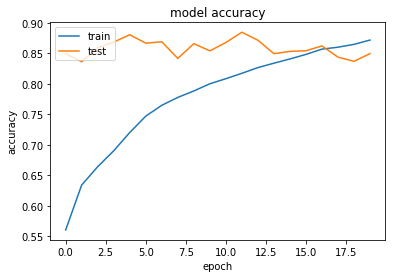

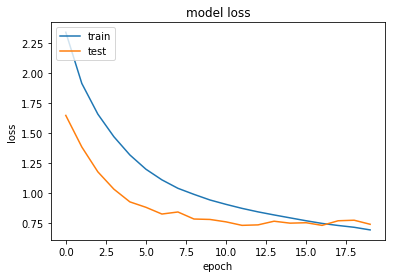

In [34]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#check train score
train_pred = model.predict([padded_docs_original, X_actual_train])
train_pred = np.argmax(to_categorical(y_actual_train),axis=-1)



In [0]:
predicted = [LABELS[int(a)] for a in train_pred]
actual = [LABELS[int(a)] for a in y_actual_train]
print('F1 macro-average score on train set :', f1_score(actual, predicted, average='macro') )
print("FNC Scores on the train set :")
report_score(actual,predicted)

In [0]:
#check val score
val_pred = model.predict(X_val)
val_pred = np.argmax(val_pred,axis=-1)



In [36]:
predicted = [LABELS[int(a)] for a in val_pred]
actual = [LABELS[int(a)] for a in y_val]
print('F1 macro-average score on val set :', f1_score(actual, predicted, average='macro') )
print("FNC Scores on the val set :")
report_score(actual,predicted)

F1 macro-average score on val set : 0.5215523306223461
FNC Scores on the val set :
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    365    |    61     |    300    |    10     |
-------------------------------------------------------------
| disagree  |    66     |    29     |    70     |     3     |
-------------------------------------------------------------
|  discuss  |    646    |    208    |    916    |    12     |
-------------------------------------------------------------
| unrelated |    63     |    24     |    41     |   7181    |
-------------------------------------------------------------
Score: 3443.0 out of 4513.25	(76.28648978009196%)


76.28648978009196

In [37]:
test_data = pd.read_csv(root_path+"comp_feature_data.csv")
test_data.head()
#filter_test = test_data[test_data['stance']!=3]
feature_test = test_data.as_matrix(columns=test_data.columns[4:])
len(feature_test[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


49

In [38]:
test_head_and_body = pre_process_data(test_data['headline'],test_data['body_id'])
test_padded_docs, test_vocab_size, test_tokeniser = get_encoded_input(test_head_and_body)

headline and body vocab size : 10609


In [0]:
y_pred = model.predict([test_padded_docs,feature_test])
y_class_pred = np.argmax(y_pred,axis=-1)

In [40]:
predicted = [LABELS[int(a)] for a in y_class_pred]
actual = [LABELS[int(a)] for a in test_data['stance']]
print('F1 macro-average score on test set :', f1_score(actual, predicted, average='macro') )
print("FNC Scores on the test set :")
report_score(actual,predicted)

F1 macro-average score on test set : 0.4441005558482126
FNC Scores on the test set :
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    911    |    259    |    537    |    196    |
-------------------------------------------------------------
| disagree  |    244    |    45     |    171    |    237    |
-------------------------------------------------------------
|  discuss  |   1979    |    486    |   1520    |    479    |
-------------------------------------------------------------
| unrelated |    164    |    37     |    639    |   17509   |
-------------------------------------------------------------
Score: 7772.25 out of 11651.25	(66.70743482458964%)


66.70743482458964

In [0]:
model.save('my_model_78.15.best.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model